# Installation of Required Libraries

This cell installs the necessary libraries for the project, including:
- `deeplake`: A data lake for machine learning.
- `torch`: The main library for deep learning.
- `torchvision`: A package for image processing in PyTorch.
- `timm`: A library for accessing various image models.
- `tqdm`: A progress bar library for Python.
- `matplotlib`: A plotting library for visualizing data.


In [8]:
!pip install deeplake torch torchvision timm tqdm matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.7/617.7 kB 8.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 87.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.9 MB/s eta 0:00:00
  Created wheel for deeplake: filename=deeplake-3.9.25-py3-none-any.whl size=740510 sha256=32499e6307c3e941749167724782518b5eb02e9c36eef2c80c17c7cca2ae9605
  Stored in directory: /root/.cache/pip/wheels/7a/02/97/6ab978e70584f6615cbe32185ff91b227f1b318a8483e2d417
Successfully

# Importing all the required libraries

In [9]:
import deeplake
import torch
from torch import nn, optim
from torchvision import transforms
from timm import create_model
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Image Transformation Pipeline

This cell defines a series of transformations to preprocess images before feeding them into the model. The transformations include:
1. **Resize**: Resizes the images to a uniform size of 224x224 pixels.
2. **ToTensor**: Converts the images to PyTorch tensors.
3. **Normalize**: Normalizes the images using the specified mean and standard deviation values for each color channel, which helps in accelerating the training process.


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load PACS dataset from DeepLake

In [11]:
ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

-

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



/

hub://activeloop/pacs-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test



|

hub://activeloop/pacs-test loaded successfully.



In [32]:
# Access and print the available keys/attributes in the training dataset
# print("Available attributes in Training Dataset:")
# for key in ds_train:
#     print(key)

# print("\nAvailable attributes in Testing Dataset:")
# for key in ds_test:
#     print(key)

train_images = ds_train['images']
train_labels = ds_train['labels']
train_domains = ds_train['domains']

print(train_domains)

# Access the domains tensor from the training dataset
train_domains = ds_train['labels'].numpy().flatten()  # Convert to NumPy array and flatten
test_domains = ds_test['labels'].numpy().flatten()    # Same for testing dataset

# Display the unique domain values in the training dataset
print("Unique domains in Training Dataset:")
unique_train_domains = set(train_domains)  # Use a set to get unique values
print(unique_train_domains)

# Display the unique domain values in the testing dataset
print("\nUnique domains in Testing Dataset:")
unique_test_domains = set(test_domains)  # Same for testing dataset
print(unique_test_domains)

# Optionally, display the first few values to understand the structure
print("\nFirst 10 Train Domains:", train_domains[:10])
print("First 10 Test Domains:", test_domains[:10])


Tensor(key='domains')
Unique domains in Training Dataset:
{0, 1, 2, 3, 4, 5, 6}

Unique domains in Testing Dataset:
{0, 1, 2, 3, 4, 5, 6}

First 10 Train Domains: [0 0 0 0 0 0 0 0 0 0]
First 10 Test Domains: [0 0 0 0 0 0 0 0 0 0]


# Custom DataLoader Function

This cell defines a custom DataLoader for processing datasets with specific domain filtering. The `custom_dataloader` function creates a DataLoader that operates on the following principles:

1. **PACSDataset Class**:
   - Inherits from `torch.utils.data.Dataset`.
   - Initializes with a dataset, transformation, and optional domains to include.
   - Filters the dataset based on specified domains by creating an index list.

2. **Methods**:
   - `__len__`: Returns the number of samples in the filtered dataset.
   - `__getitem__`: Retrieves an image and its corresponding label by using the filtered indices. It converts the image from a NumPy array to a PIL image and applies the specified transformations.

3. **DataLoader Creation**:
   - A DataLoader is created with the defined dataset, batch size, and shuffling option.
   - The function returns both the DataLoader and the length of the dataset.


In [12]:
def custom_dataloader(ds, transform, batch_size=32, shuffle=False, domains_to_include=None):
    class PACSDataset(torch.utils.data.Dataset):
        def __init__(self, ds, transform, domains_to_include):
            self.ds = ds
            self.transform = transform
            self.domains_to_include = domains_to_include
            self.indices = [i for i in range(len(self.ds['images'])) if self.ds['domains'][i].numpy() in self.domains_to_include]

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            idx = self.indices[idx]
            image = self.ds['images'][idx].numpy()
            label = int(self.ds['labels'][idx].numpy())
            image = Image.fromarray(image)
            image = self.transform(image)

            return image, label

    dataset = PACSDataset(ds, transform, domains_to_include)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader, len(dataset)

# DataLoader Initialization

This cell initializes the training and testing DataLoaders by specifying the domains to include for each dataset. The following steps are performed:

1. **Domain Specification**:
   - `train_domains`: List of domains for the training set (e.g., 0 for Art Paintings).
   - `test_domains`: List of domains for the testing set (e.g., 2 for Photo, 1 for Cartoons, 3 for Sketches).
2. **Creating DataLoaders**:
   - The training DataLoader is created by calling `custom_dataloader` with the training dataset and specified training domains, with shuffling enabled.
   - The testing DataLoader is created similarly, but without shuffling.



In [13]:
train_domains = [0]
test_domains = [1, 2, 3]

train_loader, num_train_images = custom_dataloader(ds_train, transform, batch_size = 32, shuffle=True, domains_to_include=train_domains)
test_loader, num_test_images = custom_dataloader(ds_train, transform, batch_size = 32, shuffle=False, domains_to_include=test_domains)
print(f'Number of images in the training set (after filtering domains): {num_train_images}')
print(f'Number of images in the test set (after filtering domains): {num_test_images}')

/opt/conda/lib/python3.10/site-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Number of images in the training set (after filtering domains): 1840
Number of images in the test set (after filtering domains): 7137


In [31]:
# Function to check the domains of the images in the dataloader
def check_loader_domains(data_loader, domain_array):
    domains_found = set()  # To store unique domains found in the loader
    for images, labels in data_loader:
        for label in labels:
            domains_found.add(label.item())  # Convert label to a Python scalar and add to the set
    return domains_found

# Check domains in training loader
train_domains_found = check_loader_domains(train_loader, train_domains)
print(f"Unique domains found in Training Loader: {train_domains_found}")

# Check domains in testing loader
test_domains_found = check_loader_domains(test_loader, test_domains)
print(f"Unique domains found in Testing Loader: {test_domains_found}")


/tmp/ipykernel_30/1021194798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds['labels'][idx].numpy())


Unique domains found in Training Loader: {0, 1, 2, 3, 4, 5, 6}
Unique domains found in Testing Loader: {0, 1, 2, 3, 4, 5, 6}


# Image Visualization

This cell visualizes a sample image from the training dataset. The following steps are performed:

1. **Unnormalize Function**:
   - Defines a function to revert the normalization applied to the images, allowing for proper visualization. This function takes a tensor, mean, and standard deviation as inputs.

2. **Fetching a Batch**:
   - Retrieves a batch of images and their corresponding labels from the `train_loader`.

3. **Selecting an Image**:
   - Selects the first image and its label from the fetched batch.

4. **Unnormalizing the Image**:
   - The selected image is unnormalized using the predefined mean and standard deviation values.

5. **Preparation for Visualization**:
   - Converts the tensor to a NumPy array and prepares it for visualization by permuting the dimensions.

6. **Displaying Image Information**:
   - Prints the size and label of the image.

7. **Plotting the Image**:
   - Displays the image using Matplotlib, with the title set to the corresponding label and axes turned off for better presentation.


/tmp/ipykernel_30/1021194798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds['labels'][idx].numpy())


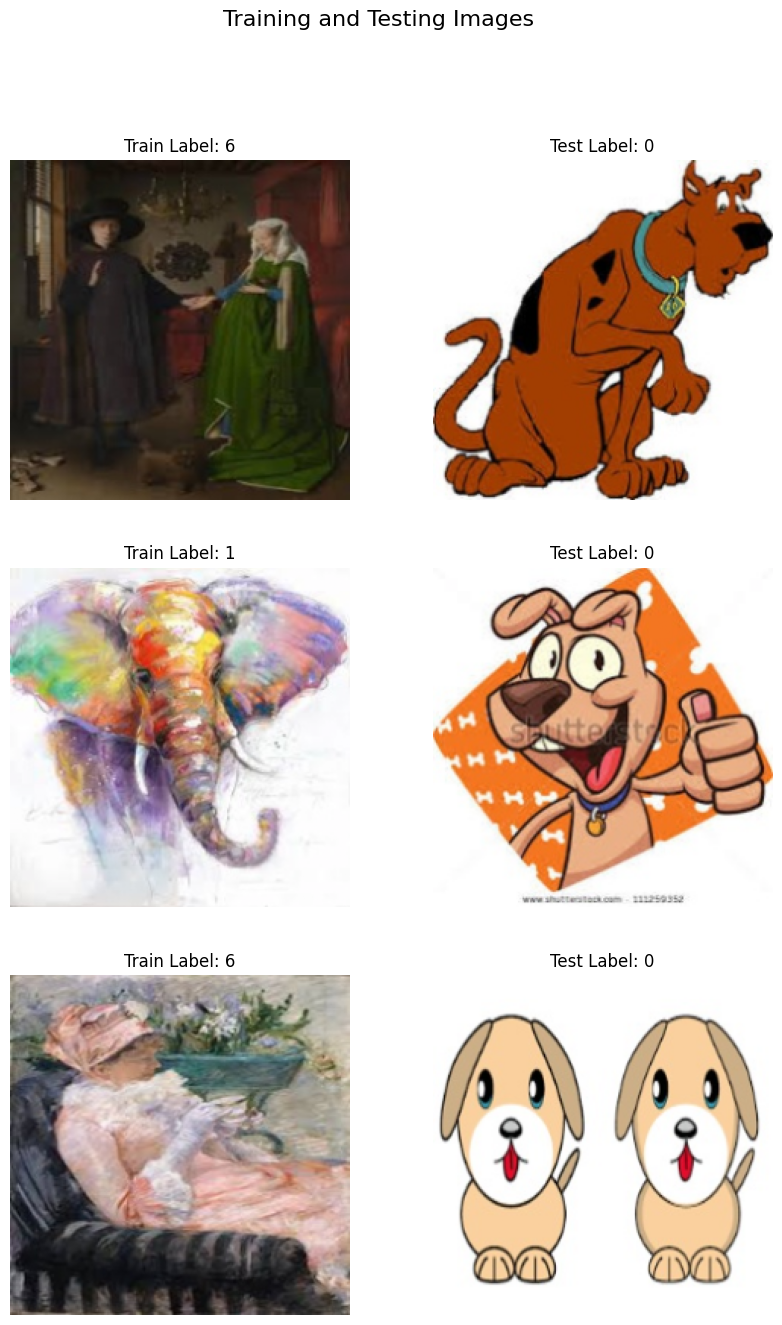

Combined image saved as: ./combined_train_test_images.png
Download combined_train_test_images.zip from the 'Files' tab in Kaggle.


In [42]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import shutil

# Function to unnormalize images
def unnormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Function to show images with labels
def show_combined_images(train_images, train_labels, test_images, test_labels):
    # Create subplots
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))
    fig.suptitle('Training and Testing Images', fontsize=16)

    # Plot training images
    for i in range(3):
        img = unnormalize(train_images[i], mean, std).permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Train Label: {train_labels[i]}')

    # Plot testing images
    for i in range(len(test_images)):  # Adjusted to ensure we only access available images
        img = unnormalize(test_images[i], mean, std).permute(1, 2, 0).numpy()
        axes[i, 1].imshow(img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Test Label: {test_labels[i]}')

    # Set column titles
    axes[0, 0].set_ylabel('Training Images', fontsize=14)
    axes[0, 1].set_ylabel('Testing Images', fontsize=14)

    # Save the combined image
    combined_image_path = './combined_train_test_images.png'
    plt.savefig(combined_image_path, bbox_inches='tight')
    plt.show()

    return combined_image_path

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Get 3 training images
train_images, train_labels = next(iter(train_loader))
train_images = train_images[:3]  # Get only the first 3 training images

# Get 3 test images (one from each domain)
test_images, test_labels = next(iter(test_loader))
test_images = test_images[:3]
domain_images = []
domain_labels = []
domain_ids = []
domains_test = [1,2,3]
# Iterate over test images to collect one from each domain
for img, label, domain in zip(test_images, test_labels, domains_test):
    domain_id = domain
    if domain_id not in domain_ids:
        domain_ids.append(domain_id)
        domain_images.append(img)
        domain_labels.append(label.item())
    if len(domain_ids) == len(test_domains):  # Stop when we have one image per domain
        break

# Check if we have less than 3 images
if len(domain_images) < 3:
    print(f"Warning: Only {len(domain_images)} images were found across the specified domains. Displaying available images.")
else:
    domain_images = domain_images[:3]
    domain_labels = domain_labels[:3]

# Display combined images
combined_image_path = show_combined_images(train_images, train_labels[:3], test_images, test_labels[:3])

# Zip the combined image for downloading
shutil.make_archive('combined_train_test_images', 'zip', os.path.dirname(combined_image_path), os.path.basename(combined_image_path))

# Inform user about downloading
print(f"Combined image saved as: {combined_image_path}")
print("Download combined_train_test_images.zip from the 'Files' tab in Kaggle.")


# Model Initialization and Configuration

This cell initializes the model and configures it for training. The following steps are performed:

1. **Model Creation**:
   - Creates a Vision Transformer (ViT) model (`vit_base_patch16_224`) with pretrained weights and moves it to the selected device.

2. **Layer Freezing**:
   - Freezes all layers of the model except for the classification head, ensuring that only the final layer's weights will be updated during training.

3. **Classifier Head Replacement**:
   - Replaces the existing classifier head with a new linear layer that outputs predictions for 7 classes (as per the PACS dataset).

4. **Model Transfer**:
   - Moves the modified model to the appropriate device (CPU or GPU).

5. **Loss Function and Optimizer**:
   - Defines the loss function as Cross Entropy Loss and initializes the Adam optimizer to update only the parameters of the classifier head at a learning rate of $1 \times 10^{-4}$.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_base_patch16_224', pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
model.head = nn.Linear(model.head.in_features, 7)
model.head.requires_grad = True
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Model Training

This cell trains the model over a specified number of epochs. The following steps are performed:

1. **Initialization**:
   - Initializes lists to store training losses and accuracies.
   - Sets the number of epochs to 3.

2. **Training Loop**:
   - Iterates through each epoch, setting the model to training mode.
   - Initializes variables to track the running loss, correct predictions, and total samples.

3. **Batch Processing**:
   - For each batch in the `train_loader`, the following operations are performed:
     - Moves the images and labels to the appropriate device.
     - Resets the optimizer gradients.
     - Computes model outputs and calculates the loss.
     - Backpropagates the loss and updates the model parameters.
     - Accumulates the running loss and counts the correct predictions.

4. **Epoch Metrics**:
   - Computes the average loss and accuracy for the epoch.
   - Appends the loss and accuracy to their respective lists.

5. **Logging**:
   - Prints the epoch number, loss, and accuracy after each epoch.


In [10]:
train_losses = []
train_accuracies = []
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")


  0%|          | 0/58 [00:00<?, ?it/s]/tmp/ipykernel_30/1021194798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds['labels'][idx].numpy())
100%|██████████| 58/58 [04:31<00:00,  4.68s/it]


Epoch [1/3], Loss: 1.9428, Accuracy: 27.01%


100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Epoch [2/3], Loss: 1.1418, Accuracy: 63.97%


100%|██████████| 58/58 [00:25<00:00,  2.30it/s]

Epoch [3/3], Loss: 0.7543, Accuracy: 80.98%


# Model Evaluation

This cell evaluates the model's performance on the test dataset. The following steps are performed:

1. **Model Evaluation Mode**:
   - Sets the model to evaluation mode, disabling dropout and batch normalization.

2. **Correctness Tracking**:
   - Initializes counters for the correct predictions and total samples.

3. **Inference Loop**:
   - Iterates through the `test_loader` without tracking gradients to improve performance. For each batch, the following operations are performed:
     - Moves the images and labels to the appropriate device.
     - Computes the model outputs.
     - Determines the predicted class by finding the index of the maximum output value.
     - Updates the total count of samples and counts the correct predictions.

4. **Results Logging**:
   - Prints the number of correct and total samples.
   - Computes and prints the test accuracy as a percentage on the PACS dataset.


In [11]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("number of correct samples: ", correct)
print("number of total samples: ", total)

test_accuracy = 100 * correct / total
print(f'Test Accuracy on PACS dataset: {test_accuracy:.2f}%')

  0%|          | 0/224 [00:00<?, ?it/s]/tmp/ipykernel_30/1021194798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds['labels'][idx].numpy())
100%|██████████| 224/224 [01:46<00:00,  2.10it/s]

number of correct samples:  3582
number of total samples:  7137
Test Accuracy on PACS dataset: 50.19%


# Plotting the training loss and accuracy for VIT on PACS

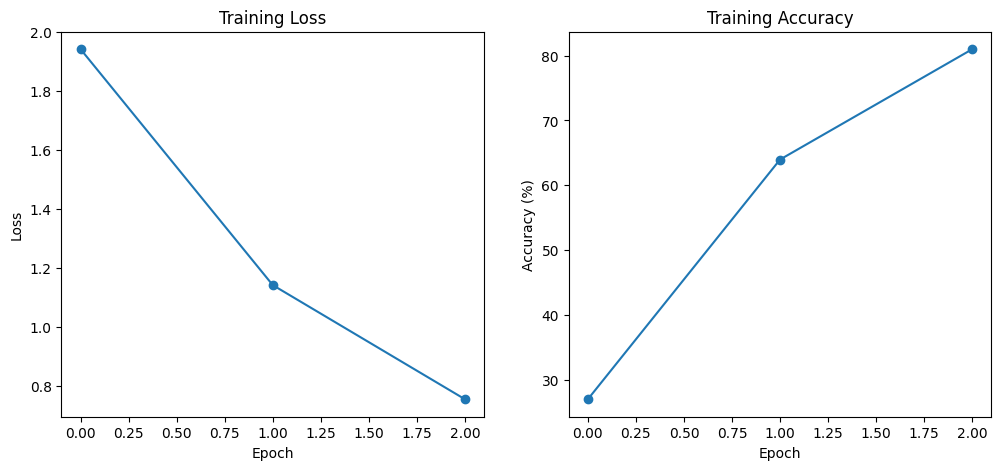

In [12]:
# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

# Model Initialization and Configuration

This cell initializes the model and configures it for training. The following steps are performed:

1. **Model Creation**:
   - Creates a Resnet model (`models.resnet101`) with pretrained weights and moves it to the selected device.

2. **Layer Freezing**:
   - Freezes all layers of the model except for the classification head, ensuring that only the final layer's weights will be updated during training.

3. **Classifier Head Replacement**:
   - Replaces the existing classifier head with a new linear layer that outputs predictions for 7 classes (as per the PACS dataset).

4. **Model Transfer**:
   - Moves the modified model to the appropriate device (CPU or GPU).

5. **Loss Function and Optimizer**:
   - Defines the loss function as Cross Entropy Loss and initializes the Adam optimizer to update only the parameters of the classifier head at a learning rate of $1 \times 10^{-4}$.


In [13]:
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = models.resnet101(pretrained=True).to(device)
for param in resnet_model.parameters():
    param.requires_grad = False
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 7)
resnet_model.fc.requires_grad = True
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 178MB/s]  


# Training Loop for finetuning Resnet on PACS

In [14]:
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")



  0%|          | 0/58 [00:00<?, ?it/s]/tmp/ipykernel_30/1021194798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds['labels'][idx].numpy())
100%|██████████| 58/58 [00:17<00:00,  3.41it/s]


Epoch [1/3], Loss: 1.7041, Accuracy: 39.51%


100%|██████████| 58/58 [00:15<00:00,  3.80it/s]


Epoch [2/3], Loss: 1.3486, Accuracy: 65.54%


100%|██████████| 58/58 [00:15<00:00,  3.74it/s]

Epoch [3/3], Loss: 1.0908, Accuracy: 80.54%


# Testing Loop for evaluating Resnet on PACS

In [15]:
# Evaluation on the test dataset
resnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("number of correct samples: ", correct)
print("number of total samples: ", total)
test_accuracy = 100 * correct / total

print(f'Test Accuracy on PACS dataset: {test_accuracy:.2f}%')



  0%|          | 0/224 [00:00<?, ?it/s]/tmp/ipykernel_30/1021194798.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds['labels'][idx].numpy())
100%|██████████| 224/224 [00:55<00:00,  4.01it/s]

number of correct samples:  3305
number of total samples:  7137
Test Accuracy on PACS dataset: 46.31%


# Plotting the training loss and accuracy of RESNET on PACS

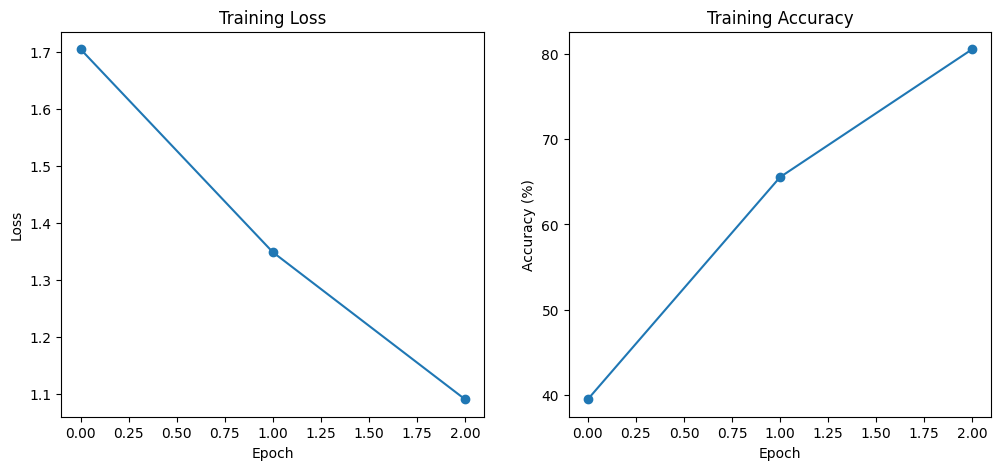

In [16]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

# Loading CLIP Models

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# Load the pre-trained CLIP model and processor (large version)
clip_model_pacs = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

  warnings.warn(


# Loading a custom dataset for my CLIP PACS test dataloader

In [ ]:

# Define the custom dataset class without transformations
class PACSDataset(torch.utils.data.Dataset):
    def __init__(self, deeplake_dataset):
        self.dataset = deeplake_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['images'].numpy()
        label = self.dataset[idx]['labels'].numpy().item()

        if image.dtype != 'uint8':
            image = (255 * image).astype('uint8')

        if image.ndim == 2:
            image = Image.fromarray(image, mode='L')
        elif image.shape[2] == 3:
            image = Image.fromarray(image, mode='RGB')
        elif image.shape[2] == 4:
            image = Image.fromarray(image, mode='RGBA')
        else:
            raise ValueError(f"Unsupported number of channels: {image.shape[2]}")

        return image, label

def custom_collate_fn(batch):
    images, labels = zip(*batch)
    labels = torch.tensor(labels)
    return list(images), labels

# Load Deep Lake datasets
ds_train = deeplake.load('hub://activeloop/pacs-train', read_only=True)

pacs_train_dataset = PACSDataset(ds_train)
print(len(pacs_train_dataset))
train_data_loader = DataLoader(
    pacs_train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=custom_collate_fn
)


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train




-

hub://activeloop/pacs-train loaded successfully.



8977


# Defining class names and text inputs

In [ ]:
class_names = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
text_inputs = processor(text=[f"A photo of a {label}" for label in class_names], return_tensors="pt", padding=True).to('cuda')
print(text_inputs)

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  1929, 49407],

        [49406,   320,  1125,   539,   320, 10299, 49407],

        [49406,   320,  1125,   539,   320, 22826, 49407],

        [49406,   320,  1125,   539,   320,  5084, 49407],

        [49406,   320,  1125,   539,   320,  4558, 49407],

        [49406,   320,  1125,   539,   320,  1212, 49407],

        [49406,   320,  1125,   539,   320,  2533, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],

        [1, 1, 1, 1, 1, 1, 1],

        [1, 1, 1, 1, 1, 1, 1],

        [1, 1, 1, 1, 1, 1, 1],

        [1, 1, 1, 1, 1, 1, 1],

        [1, 1, 1, 1, 1, 1, 1],

        [1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


# Zero shot evaluation by clip on PACS

In [ ]:
# Zero-shot evaluation on train set
clip_model_pacs.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(train_data_loader):
        # Process the images using the CLIP processor
        image_inputs = processor(images=images, return_tensors="pt", padding=True).to('cuda')

        # Get image and text features from CLIP
        image_features = clip_model_pacs.get_image_features(**image_inputs)
        text_features = clip_model_pacs.get_text_features(**text_inputs)

        # Normalize features for cosine similarity
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute similarity between image and text features
        similarities = (image_features @ text_features.T).softmax(dim=-1)  # (batch_size, num_classes)

        # Get predictions
        predictions = similarities.argmax(dim=-1)

        # Update the correct and total counts
        correct += (predictions == labels.cuda()).sum().item()
        total += labels.size(0)

# Print zero-shot accuracy on the train set
accuracy = correct / total * 100
print(f'Zero-shot CLIP accuracy on PACS train set: {accuracy:.2f}%')

100%|██████████| 281/281 [07:29<00:00,  1.60s/it]

Zero-shot CLIP accuracy on PACS train set: 97.66%
